# Data Analysis for Mobile gaming

Here we have a data set of mobile game. We see the first row of the dataset below:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns

In [2]:
df=pd.read_csv('mibilegame.csv')
df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False


In [3]:
sum(df['userid'].duplicated())

0

In [4]:
df.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

users which are in "gate_40" are those who had seen the advertisement of the new version. But the people in group "gate_30" did not see that.
In the following they are labeled as "df_ad" and "df_noAd" respectively. 
The average of sum_gamerounds in each group shows that the advertisement had no positive effect on the engagement of the users: 

In [9]:
df_ad=df[df.version=='gate_40']
df_noAd=df[df.version=='gate_30']
ad_mean, noAd_mean = df_ad.sum_gamerounds.mean() , df_noAd.sum_gamerounds.mean()
origional_mean_diff = df_ad.sum_gamerounds.mean() - df_noAd.sum_gamerounds.mean()
print(f"ad_mean   = {ad_mean}")
print(f"noAd_mean = {noAd_mean}")
print(f"ad_mean - noAd_mean = { origional_mean_diff}")

ad_mean   = 51.29877552814966
noAd_mean = 52.45626398210291
ad_mean - noAd_mean = -1.157488453953249


As stated above, advertisement did not increases the sum_gamerounds. Even we had decrease in sum_grounds in average.
Therefore we obviously does not need to check wether advertisement was the reason for positive effect on sum_game_rounds or not (because it had not positive effect).



# More Investigations:
We understood that advertisement had not positive effect on sum_game_rounds.
But now, we want to check whether the decrease in sum_game_rounds is by chance or bad way of advertisements was the reaseon of this reduction in users' tendency.
We implement this using 2 ways:  U-test way and  A/B testing simulation

## statistical tests: U-test check
 We can check the causition either by T-test or U-test . 
 For using T-test it is required that we check the distributions of our two groups (i.e. ad and naAd groups) follow the normal distribution or not. To check this out, we use Shapiro test:

In [6]:
#plt.hist([df_noad.sum_gamerounds] , bins=50)
shapiro_pval_ad_group=stats.shapiro(df_noAd.sum_gamerounds)[1]
shapiro_pval_noAd_group=stats.shapiro(df_ad.sum_gamerounds)[1]
if shapiro_pval_ad_group>0.05 and shapiro_pval_noAd_group>0.05  :
    print( "The sum_gamerounds for users of version gate_40 and gate_30 follow normal distribution. Ttest can be done!")
else:
    print( "The sum_gamerounds for users of either version gate_30 or gate_40 does not follow normal distribution. The T test can not be done!")

The sum_gamerounds for users of either version gate_30 or gate_40 does not follow normal distribution. The T test cann not be done!


C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


As we saw the disributions are not normal and we cannot use T-test. So, the U-test is our choice and you can see the results:


In [8]:
confidence_level=0.05
u_stat, p_value = stats.mannwhitneyu(df_noAd['sum_gamerounds'] , df_ad['sum_gamerounds'] , alternative='greater')
print (f"The u-test 's p_value is {p_value} and confidence level is : {confidence_level}. Hence: ")
if p_value < confidence_level:
    print('U-test confirms that bad advertisements tended to the reduction of sum_gamerounds')
else:
    print("There is no evidence that sum_gamerounds' reduction is due to the bad advertisements.")

The u-test 's p_value is 0.025104403860221274 and confidence level is : 0.05. Hence: 
U-test confirms that bad advertisements tended to the reduction of sum_gamerounds


## A/B test check

In [16]:
N=10000

def sh_exp(N ,original_values  ):
    len_total=len(df)
    len_ad=len(df_ad)
    len_noAd=len(df_noAd) 
    chancy_labeled_mean_diff = np.empty([N, 1])
    for times in np.arange(N):
        chancy_labels = np.random.choice([1,0], size=len_total,  p=[len_ad/len_total ,1-len_ad/len_total ])
        chancy_labeled_data = np.array([
            chancy_labels,
            original_values
            
        ]).T
        chancy_labeled_mean_ad   = chancy_labeled_data[chancy_labeled_data[:, 0] == 1][:, 1].mean()
        chancy_labeled_mean_noAd = chancy_labeled_data[chancy_labeled_data[:, 0] == 0][:, 1].mean()
        chancy_labeled_mean_diff[times] = chancy_labeled_mean_ad - chancy_labeled_mean_noAd
    return chancy_labeled_mean_diff


e=sh_exp(N , np.array(df.sum_gamerounds) )
p_value = len(e [e <  origional_mean_diff]) / len(e)
if p_value<confidence_level:
    print(f'p_value = {p_value} implies Bad advertisements was the reason for reduction of sum of game rounds')
else:
    print(f"p_value = {p_value}. There is not enough evidences that confirm the bad advertisements was the reason for reduction in sum of game rounds")

p_value = 0.2424. There is not enough evidences that confirm the bad advertisements was the reason for reduction in sum of game rounds


<Axes: ylabel='Count'>

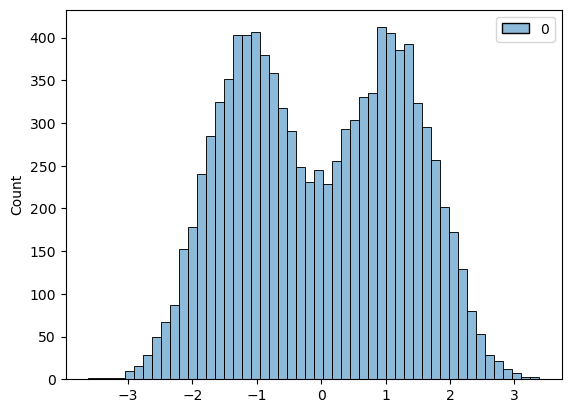

In [17]:
sns.histplot(e, bins=50)